In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import os

In [2]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
# show image function
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

## Content와 Style 표현 정의
이미지의 콘텐츠와 스타일 표현을 얻기 위해, model 내 중간 레이어(layer)를 살펴보겠습니다. 중간 레이어들은 피쳐맵(feature map)을 나타나는데 이는 깊어질수록 높이가 커지게 됩니다. 이번 경우, 미리 학습된 이미지 분류 신경망인 VGG19 신경망을 사용합니다. 이 신경망의 중간 레이어들은 이미지의 스타일과 콘텐츠 표현을 정의하는 데 필요합니다. 중간 레이어들에서 입력 이미지의 해당 스타일 및 콘텐츠가 목적 표현에도 맞춰지도록 시도합니다.

In [4]:
# Content layer where will pull our feature maps
content_layers = ['block4_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## 왜 레이어의 중간 부분을 사용하는가?
학습된 이미지 분류 신경망의 중간 레이어 출력값들이 스타일과 콘텐츠 표현을 어떻게 정의하는지 궁금할 겁니다.  
높은 단계에서, 이 현상은 신경망이 (신경망이 학습해 온)이미지 분류를 하기 위해서는 반드시 이미지를 이해해야 하는 사실로 설명될 수 있습니다. 이는 원본 이미지를 입력 픽셀(pixel)로 사용하고 원본 이미지 픽셀을 이미지 내 피쳐들의 복잡한 이해형태로 변형하는 방식으로 내부 표현을 설계합니다. 이는 CNN(Convolution Neural Network)이 얼마나 잘 일반화될 수 있는지에 대한 이유이기도 합니다. CNN은 배경이나 다른 노이즈들에 영향을 받지 않는 클래스 내에 존재하는 불변성(invariances)을 포착하고 피쳐들을 정의할 수 있습니다.  
그러므로 원본 이미지가 입력되고 분류 레이블(label)이 출력되는 구간 어딘가에서 model은 복잡한 피쳐 추출기로서 작동합니다. 따라서 중간 레이어에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 설명할 수 있습니다.

![feature](./feature.png)  
**Content Representation** : Content image를 Conv연산을 하여 얻은 feature map 
**Content Reconstruction** : Content Representation으로 Content loss를 최적화하여 만들어진 이미지  
**Style Representation** : Style image의 feature map  
**Style Reconstruction** : Style Representation을 최적화하여 만들어진 이미지   

### Content feature
레이어가 깊어지면 픽셀 수준의 정보는 사라지게 되지만 입력 이미지가 가진 semantic 정보(위 그림에서 강 옆의 집들)은 그대로 유지된다. 반면에 낮은 레이어는 입력 이미지와 거의 동일하다. 따라서 깊은 레이어에서 content feature를 추출한다.  

### Style feature
style 특성은 Gram matrix를 기반으로 한다. style/texture 특성은 공간적인 정보와 무관해야 하므로 각 레이어의 feature map 사이의 상관관계(correlation)를 나타낼 수 있는 Gram matrix를 사용하게 된다.  
[참고](https://www.popit.kr/neural-style-transfer-%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B0/)

# Model 생성
* 각 Content feature와 style feature를 얻기 위한 모델 생성(VGG19사용)

In [5]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
    return model

### Style 계산
* 행렬의 Gram Matrix를 구하고 행렬간 차이가 최소가 되도록 loss function을 계산한다.
![gram1](gram1.png)
![gram2](gram2.png)

# Transform Model

In [6]:
def _instance_norm(net):
    batch, rows, cols, channels = net.get_shape()
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keepdims=True)
    
    shift = tf.Variable(initial_value=tf.zeros(var_shape), dtype=tf.float32)
    scale = tf.Variable(initial_value=tf.ones(var_shape), dtype=tf.float32)
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift

def _conv_layer(inputs, num_filters, kernel_size, strides, padding='same', relu=True):
    net = tf.keras.layers.Conv2D(num_filters, kernel_size, strides=(strides, strides), padding=padding)(inputs)
    net = tfa.layers.InstanceNormalization()(net)
#     net = _instance_norm(net)
    if relu:
        net = tf.keras.layers.ReLU()(net)
    return net

def _conv_transpose_layer(inputs, num_filters, kernel_size, strides):
    net = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size, strides=(strides, strides), padding='same')(inputs)
    net = tfa.layers.InstanceNormalization()(net)
#     net = _instance_norm(net)
    return tf.keras.layers.ReLU()(net)

def _residual_block(net, kernel_size=3):
    batch, rows, cols, channels = tf.shape(net)
    tmp = _conv_layer(net, 128, kernel_size, 1, padding='valid', relu=True)
    shape = tf.shape(net)
#     return _conv_layer(tmp, 128, kernel_size, 1, padding='valid', relu=False) + tf.slice(net, [0,2,2,0], [batch,rows-4,cols-4,channels])
    return _conv_layer(tmp, 128, kernel_size, 1, padding='valid', relu=False) + tf.slice(net, [0,2,2,0], [shape[0],shape[1]-4,shape[2]-4,shape[3]])

def _gram_matrix(tensor, shape=None):
    if shape is not None:
        B = shape[0]  # batch size
        HW = shape[1] # height x width
        C = shape[2]  # channels
        CHW = C*HW
    else:
        B, H, W, C = tensor.get_shape()
        HW = H*W
        CHW = W*H*C

    # reshape the tensor so it is a (B, 2-dim) matrix
    # so that 'B'th gram matrix can be computed
    feats = tf.reshape(tensor, (B, HW, C))

    # leave dimension of batch as it is
    feats_T = tf.transpose(feats, perm=[0, 2, 1])

    # paper suggests to normalize gram matrix by its number of elements
    gram = tf.matmul(feats_T, feats) / CHW

    return gram

def _get_total_variation_loss(img):
    b, h, w, d = img.get_shape()
    tv_y_size = (h-1) * w * d
    tv_x_size = h * (w-1) * d
    y_tv = tf.nn.l2_loss(img[:, 1:, :, :] - img[:, :img.shape[1] - 1, :, :])
    x_tv = tf.nn.l2_loss(img[:, :, 1:, :] - img[:, :, :img.shape[2] - 1, :])
    loss = 2. * (x_tv / tv_x_size + y_tv / tv_y_size) / b

    loss = tf.cast(loss, tf.float32)
    return loss

In [7]:
def TransformModel():
    input_n = tf.keras.Input(shape=(None, None, 3), dtype=tf.float32)
    image_p = tf.pad(input_n,[[0, 0],[40, 40],[40, 40], [0, 0]], "REFLECT")
    conv1 = _conv_layer(image_p, 32, 9, 1)
    conv2 = _conv_layer(conv1, 64, 3, 2)
    conv3 = _conv_layer(conv2, 128, 3, 2)

    resid1 = _residual_block(conv3, 3)
    resid2 = _residual_block(resid1, 3)
    resid3 = _residual_block(resid2, 3)
    resid4 = _residual_block(resid3, 3)
    resid5 = _residual_block(resid4, 3)

    conv_t1 = _conv_transpose_layer(resid5, 64, 3, 2)
    conv_t2 = _conv_transpose_layer(conv_t1, 32, 3, 2)
    conv_t3 = _conv_layer(conv_t2, 3, 9, 1, relu=False)
    
    activ = tf.keras.activations.tanh(conv_t3)
    preds = (activ + 1) * (255. / 2)
    
    model = tf.keras.Model(inputs=input_n, outputs=preds)
    return model

# Style, Content Model

In [8]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers # 5
        self.content_layers = content_layers # 1
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style':style_dict}

# 학습을 위한 loss function 설정 및 파라미터 설정

In [9]:
opt = tf.optimizers.Adam(learning_rate=1e-3)

Total Loss의 가중치 파라미터를 지정한다

In [10]:
def style_content_loss(content_output, style_output, transform_output, transform_image):
    content_image_features = content_output['content'] # content featur of content image
    transform_content_features = transform_output['content'] # content feature of transform image
    style_image_features = style_output['style'] # style feature of style image
    transform_style_features = transform_output['style'] # style feature of transform image
    
    # Content Loss
    L_content = 0
    for idx in content_layers:
        F = transform_content_features[idx]  # content feature of transform image
        P = content_image_features[idx]  # content feature of content image
        
        b, h, w, d = transform_content_features[idx].get_shape()
        N = h*w
        M = d
        
        w = 1.0
        
        L_content += w * 2 * tf.nn.l2_loss(F-P) / (b*N*M)
    
    # Style Loss
    L_style = 0
    for idx in style_layers:
        F = transform_style_features[idx] # style feature of transform image
        A = style_image_features[idx] # style feature of style image
        
        b, h, w, d = F.get_shape()
        N = h*w
        M = d
        
        w = 0.2
        G = _gram_matrix(F, (b,N,M))
        A = _gram_matrix(A)
        
        L_style += w * 2 * tf.nn.l2_loss(G-A) / (b * (M ** 2))
    
    # total variation loss
    L_tv = _get_total_variation_loss(transform_image)
    
    # Total Loss
    L_total = 7.5e0*L_content + 5e2*L_style + 2e2*L_tv
    
    return L_total, L_content, L_style, L_tv

In [11]:
# VGG Model
extractor = StyleContentModel(style_layers, content_layers)
# Transform Model
transfer = TransformModel()

def train_step(content_image, style_image, transfer_model, opt): 
    with tf.GradientTape() as tape:
        original_image = content_image / 255.  # [0, 1.]
        transform_image = transfer_model(original_image) # 이미지 생성 [0, 255.]
        
        transform_image_outputs = extractor(transform_image) # 생성된 이미지의 feature
        content_image_outputs = extractor(content_image) # content image의 feature
        style_image_outputs = extractor(style_image) # style image의 feature
        
        L_total, L_content, L_style, L_tv = style_content_loss(content_image_outputs, style_image_outputs, transform_image_outputs, transform_image)
    
    transformer_grad = tape.gradient(L_total, transfer_model.trainable_variables) # loss를 기반으로 image를 학습시킴
    opt.apply_gradients(zip(transformer_grad, transfer_model.trainable_variables))
    
    return L_total, L_content, L_style, L_tv

# 학습

In [12]:
# 파라미터 
BATCH_SIZE = 4
EPOCHS = 2  

In [13]:
# 데이터 준비
def load_batch_image(start_idx, batch_size):
    train_list = os.listdir('./train2014')
    batch_images = np.zeros([batch_size, 256, 256, 3], dtype=np.float32)
    for i in range(batch_size):
        img = PIL.Image.open('./train2014/' + train_list[start_idx+i])
        img = img.resize((256, 256))
        img = np.array(img, dtype=np.float32)
        if not (len(img.shape) == 3 and img.shape[2] == 3):
            img = np.dstack((img, img, img))
        batch_images[i] = np.array(img, dtype=np.float32)

    return batch_images

In [14]:
def train(content_image_path, style_image_path, model, opt):
    
    # load model
    if not os.path.exists('la_muse_models'):
        os.mkdir('la_muse_models')
        
    ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, './la_muse_models', max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    
    if manager.latest_checkpoint:
        transfer_model = ckpt.net  # ckpt 파일이 존재한다면 불러와서 사용
        opt = ckpt.optimizer
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        transfer_model = model  # ckpt 모델이 없으면 초기에 만든 모델 사용
        opt = opt
        print("Initializing from scratch.")
    
    # load style image
    style_image = PIL.Image.open(style_image_path)
    style_image = np.array(style_image, dtype=np.float32)
    style_image = np.expand_dims(style_image, axis=0)
    
    # Load test image
    test_image = PIL.Image.open(content_image_path)
    test_image = np.array(test_image, dtype=np.float32)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Load train imageset
    coco_len = len(os.listdir('./train2014'))
    epoch_start = ckpt.step // coco_len
    
    
    for epoch in range(epoch_start, EPOCHS):
        while (ckpt.step - epoch_start * coco_len) + BATCH_SIZE < coco_len:
            content_image = load_batch_image((ckpt.step - epoch * coco_len), BATCH_SIZE)
            L_total, L_content, L_style, L_tv = train_step(content_image, style_image, transfer_model, opt)
            
            ckpt.step.assign_add(BATCH_SIZE)    
            print('epoch : %d, iter : %4d, ' % (epoch, ckpt.step),'L_total : %g, L_content : %g, L_style : %g, L_tv : %g' % (L_total, L_content, L_style, L_tv))
            if ckpt.step % 1000 == 0:
#                 print('epoch : %d, iter : %4d, ' % (epoch, ckpt.step),'L_total : %g, L_content : %g, L_style : %g, L_tv : %g' % (L_total, L_content, L_style, L_tv))
                save_path = manager.save()
                print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
                
            if ckpt.step % 2000 == 0:
                # show test image
                with tf.device('/cpu:0'):
                    image = transfer_model(test_image / 255.)
                display.clear_output(wait=True)
                display.display(tensor_to_image(image))
                
        # 남은거 처리
        content_image = load_batch_image((ckpt.step - epoch * coco_len), (ckpt.step - epoch_start * coco_len) - coco_len)
        L_total, L_content, L_style, L_tv = train_step(content_image, style_image, transfer_model, opt)
        ckpt.step.assign_add((ckpt.step - epoch_start * coco_len) - coco_len)
        
        print('epoch : %d, iter : %4d, ' % (epoch, ckpt.step),'L_total : %g, L_content : %g, L_style : %g, L_tv : %g' % (L_total, L_content, L_style, L_tv))
        save_path = ckpt.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

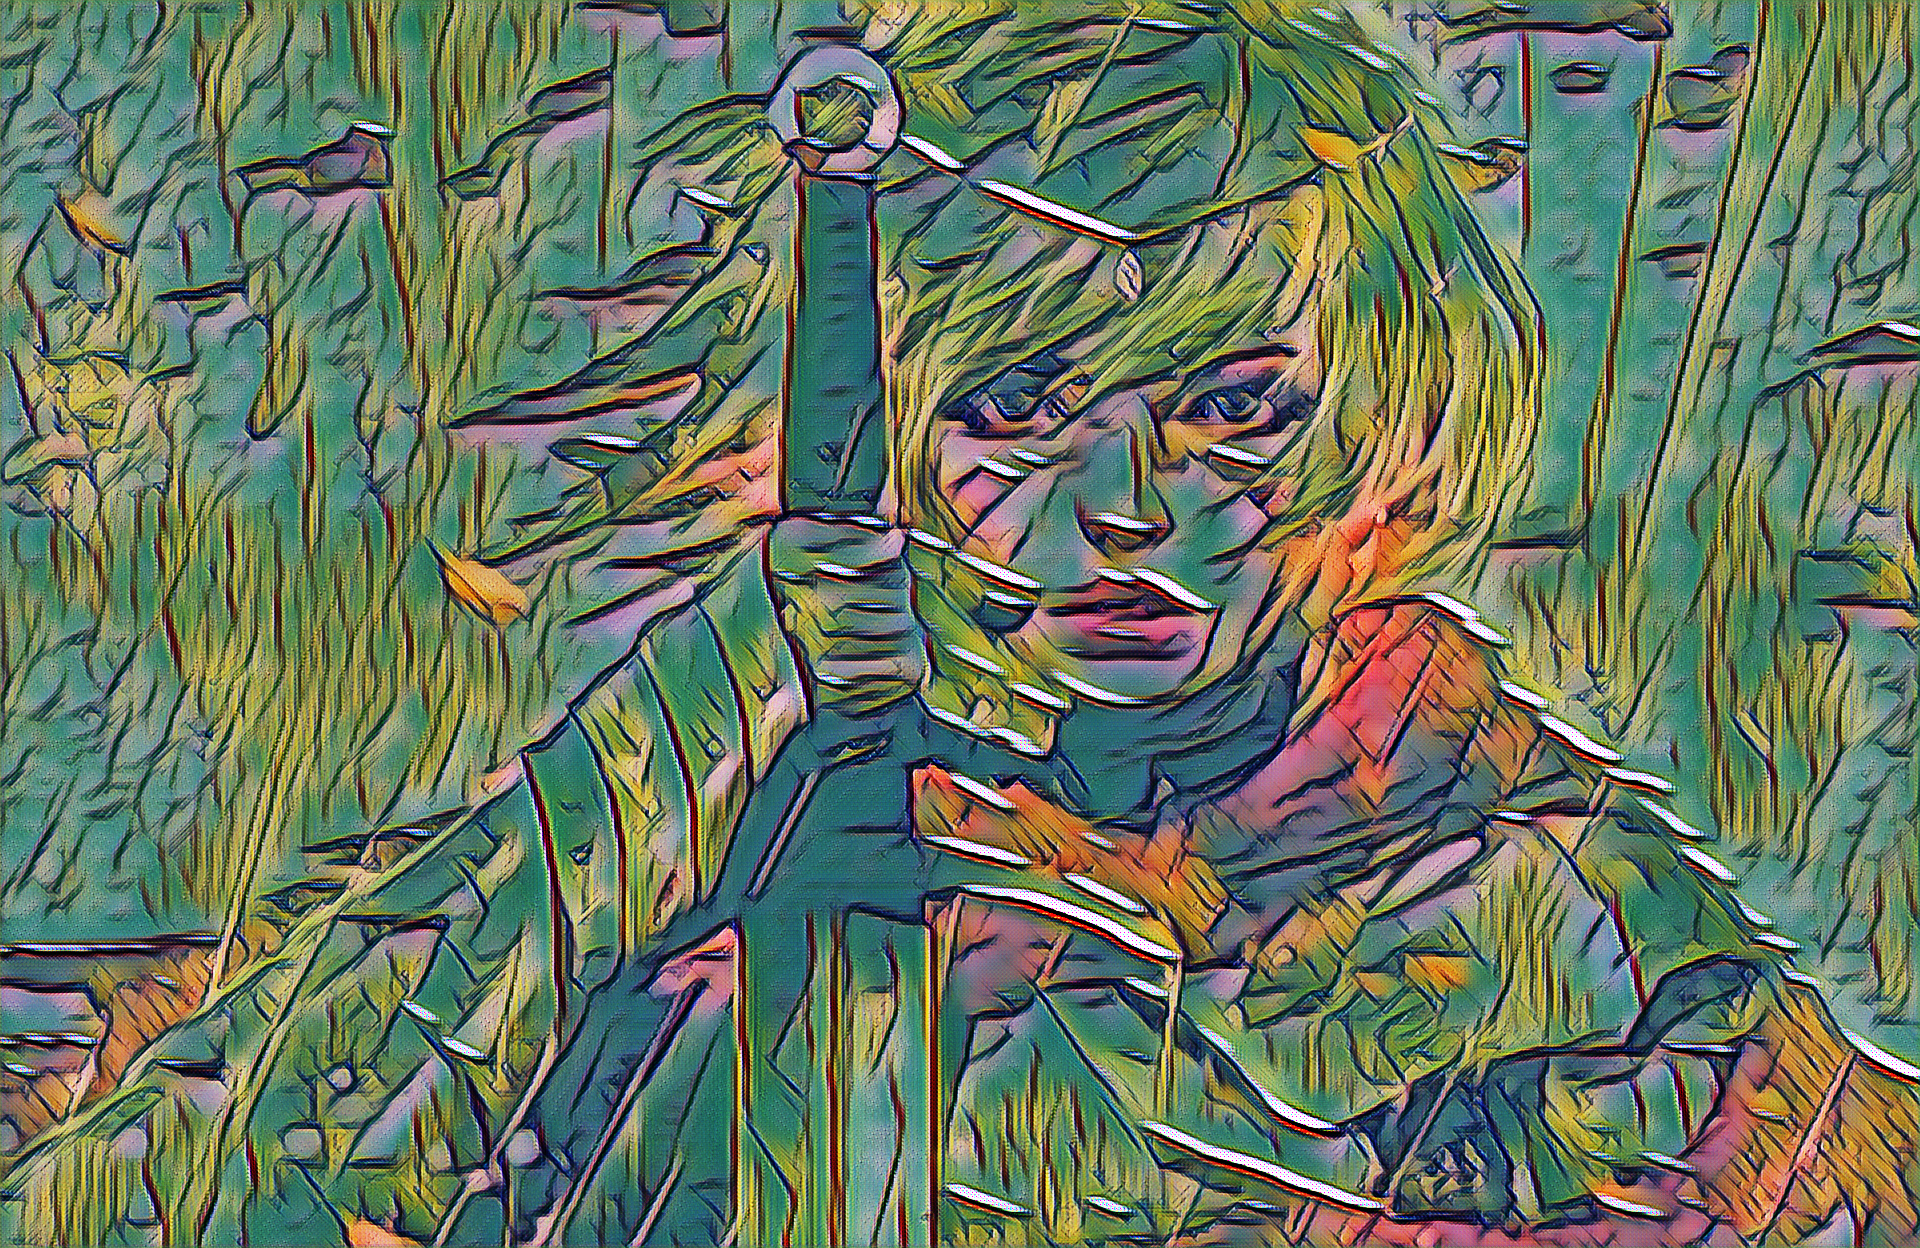

epoch : 0, iter : 22004,  L_total : 1.03357e+07, L_content : 781794, L_style : 8123.1, L_tv : 2053.61
epoch : 0, iter : 22008,  L_total : 1.20882e+07, L_content : 984672, L_style : 8575.96, L_tv : 2076.02
epoch : 0, iter : 22012,  L_total : 1.06916e+07, L_content : 785539, L_style : 8717.04, L_tv : 2207.88
epoch : 0, iter : 22016,  L_total : 1.11629e+07, L_content : 874725, L_style : 8328.78, L_tv : 2190.14
epoch : 0, iter : 22020,  L_total : 1.08502e+07, L_content : 910195, L_style : 7213.56, L_tv : 2084.85
epoch : 0, iter : 22024,  L_total : 1.37004e+07, L_content : 849186, L_style : 13862, L_tv : 2002.54


KeyboardInterrupt: 

In [15]:
train('./content/female_knight.jpg', './style/la_muse.jpg', transfer, opt)

In [ ]:
image = PIL.Image.open('./content/female_knight.jpg')
image = np.array(image, dtype=np.float32)
image = np.expand_dims(image, axis=0)

In [ ]:
# 학습안된 transfer
with tf.device('/cpu:0'):
    non_train = TransformModel()
    styles = non_train(image)
display.display(tensor_to_image(styles))

In [ ]:
train = TransformModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=opt, net=train)
manager = tf.train.CheckpointManager(ckpt, './models', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

net = ckpt.net
with tf.device('/cpu:0'):
    train = TransformModel()
    styles = net(image)
display.display(tensor_to_image(styles))

In [ ]:
tf.keras.models.save_model(net, 'test')

In [ ]:
checkpoint_dir = './models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt, net=transfer)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
with tf.device('/cpu:0'):
    styles = transfer(image)
display.display(tensor_to_image(styles))

In [ ]:
model = tf.keras.models.load_model('test')